In [56]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import datetime
import random
import string
import matplotlib.pyplot as plt
import seaborn as sns


from numba import jit
from multiprocessing import cpu_count
from dask.multiprocessing import get

nCores = cpu_count()
sns.set()

## Initializing Data

The computer I primarily use has 32GB of RAM (DDR4-3200,CAS14).  Additionally, I created a 64GB swap file partition on a Samsung 960 Evo M.2 Flash Drive (if anyone has any experience using Intel 3D XPoint for this, let me know about your experiences).  I wanted to create a dataframe that exceeded 32GB in memory to test the efficacy of Pandas vs Dask vs Spark.  The following parameters should accomplish that with 100 million rows.

The "data" contains a random date between 1900 and 2000, a random float between 0 and 1, a random int between 0 and 3333, a "categorical" string of [a-z], and two random geo points, one slightly off the other.

The random int column, `c2`, contains `NaN` values, 2% of the total.

In [84]:
nRows = 10000000
startdate = datetime.date(1900,1,1)
geoCenter = (40.723270, -73.988371)

In [85]:
### initializing random data
data = pd.DataFrame({'date':[startdate + datetime.timedelta(int(i)) for i in np.random.randint(1,36524,size=nRows)],
                     'c1':np.random.rand(nRows),
                     'c2':np.random.randint(0,3333,nRows),
                     'c3':[random.choice(string.ascii_letters).lower() for i in range(nRows)],
                     'lat_1':np.random.rand(nRows) + geoCenter[0],
                     'lon_1':np.random.rand(nRows) + geoCenter[1]
                    })

data['lat_2'] = data['lat_1']
data['lon_2'] = data['lon_1'] + 0.003

data.date = pd.to_datetime(data.date)

### picking random null values
data.loc[data.sample(frac=.02).index,'c2'] = np.nan

In [86]:
data.to_feather('/tmp/data')

In [ ]:
data = pd.read_feather('/tmp/data')

In [75]:
data_dd = dd.from_pandas(data,npartitions=4, sort=False)

## Data Pre-Processing Steps

### Dates

In column `date` we have datetime objects as if they had been parsed by pandas `read_csv` with `parse_dates`.  These are YYYY-MM-DD style, with no additional time information.

In most machine learning algorithims, we would want to separate out the individual components of a date into their own feature.  For this date, we will create five features: the year, month, week, day, and day of the week.

### Filling Missing Values


### Encoding Categorical Variables



## Python, Pandas, Single-Processor

The following function extracts the various parts of time from a datetime column and returns the original dataframe with the new features:

In [47]:
### input: dataframe, column of datetime objects, desired list of time-interval features
### output: dataframe with new time-interval features appended
def date_extractor(df, dateCol, interval=['year','month','week','day','dayofweek']):
    df.is_copy = False # we're not dealing with copies, this avoids the warning
    for i in interval:
        df.loc[:,i] = eval('df.%s.dt.%s'% (dateCol,i))
    return df

In [110]:
results_dates = pd.DataFrame({'pandas':[],
                                     'nRows':[]
                                    })

for i,nIter in enumerate(10 ** np.arange(0,9)): 
    print('Size: %s'% nIter)
    out1_ = %timeit -n 1 -r 3 -o _ = date_extractor(data.head(nIter),'date')
    row = {'pandas':out1_.average,
           'nRows':nIter
          }
    results_dates.loc[i] = row

Size: 1
7.44 ms ± 986 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 10
6.86 ms ± 1.44 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 100
6.25 ms ± 584 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 1000
5.9 ms ± 279 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 10000
10 ms ± 487 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 100000
52.9 ms ± 1.86 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 1000000
562 ms ± 10.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 10000000
6.2 s ± 19.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 100000000
6.17 s ± 7.46 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
from pyspark import SparkContext, SparkConf

conf = SparkConf().setMaster('local[*]').setAppName('parallel_preprocessing')
sc = SparkContext.getOrCreate(conf=conf)

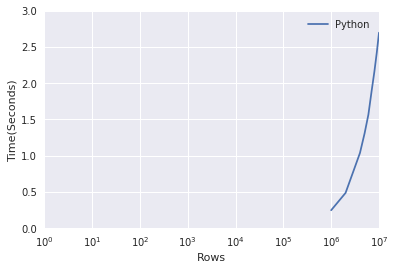

In [107]:
fig, ax = plt.subplots()
ax.plot((results_dates_pandas.nRows), results_dates_pandas.pandas, label='Python')
ax.set_xlabel("Rows")
ax.set_ylabel("Time(Seconds)")
ax.set_xscale('log')
ax.axis([1,10000000,0,3])
ax.legend()
#fig.savefig('./python_numba_only.png',dpi=300)